In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import scipy.stats

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms, models
import tqdm

from ray import tune

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2


import autonomous_optimizer
import benchmark

First, we will examine performance on convex quadratic objective functions. We generate 90 convex quadratics in two dimensions with eigenvalues uniformly distributed between 1 and 10 as the train set.

In [10]:
iterations = 40
dataset = [benchmark.convex_quadratic() for _ in range(90)]

Now we define the RL environment and our model.

In [14]:
env = autonomous_optimizer.Environment(dataset, iterations)
policy = PPO2(MlpPolicy, env, n_steps=8, verbose=0, tensorboard_log='tb_logs')

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/envs/learn-to-optimize/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:202: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn("Your observation has an unconventional shape (neither an image, nor a 1D vector). "
/opt/anaconda3/envs/learn-to-optimize/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


Instructions for updating:
Use tf.cast instead.


We will use tensorboard to get a sense of reward, loss, and other metrics as we train.

In [15]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

Reusing TensorBoard on port 6006 (pid 18570), started 1:34:51 ago. (Use '!kill 18570' to kill it.)

Train the algorithm on 20 passes over the dataset

In [16]:
policy.learn(total_timesteps=20 * iterations * len(dataset))

We will be comparing the RL optimizer to several common convex optimization algorithms. We use Bayesian optimization to find good hyperparameters for this class of problems. And to make this a fair comparison, we will run 20 passes over all problems in the dataset, just like the RL algorithm gets.

In [25]:
quadratic_tune = benchmark.tune_algos(
    dataset,
    iterations,
    tune_iters=20,
    hyperparam_space={
        "lr": tune.loguniform(1e-5, 5e-1),
        "momentum": tune.uniform(0.7, 1)
    },
    algos=["sgd", "momentum", "adam"]
)

print('Final hyperparam values:')
for algo, results in quadratic_tune.items():
    print(f'  {algo}: {results["hyperparams"]}')

100%|██████████| 3/3 [00:51<00:00, 17.19s/it]

Final hyperparam values:
  sgd: {'lr': 0.3169881321274159}
  momentum: {'nesterov': True, 'lr': 0.10905361907161754, 'momentum': 0.8178527304006111}
  adam: {'lr': 0.21346669540892085}


Now, let's compare their behavior on an example problem.

In [20]:
problem = benchmark.convex_quadratic()

model0 = problem["model0"]
obj_function = problem["obj_function"]
optimal_x = problem["optimal_x"]
optimal_value = problem["optimal_val"]
A = problem["A"]
b = problem["b"]
    
print(f'Objective function minimum: {optimal_value}')

Objective function minimum: -0.01685558818280697


Run algos with our tuned hyperparams

In [22]:
# SGD
sgd_quadratic_vals, sgd_quadratic_traj = benchmark.run_optimizer(
    torch.optim.SGD, problem, iterations, quadratic_tune['sgd']['hyperparams'])
print(f'SGD optimality gap: {sgd_quadratic_vals.min() - optimal_value}')

# Momentum
momentum_quadratic_vals, momentum_quadratic_traj = benchmark.run_optimizer(
    torch.optim.SGD, problem, iterations, quadratic_tune['momentum']['hyperparams'])
print(f'Momentum optimality gap: {momentum_quadratic_vals.min() - optimal_value}')

# Adam
adam_quadratic_vals, adam_quadratic_traj = benchmark.run_optimizer(
    torch.optim.Adam, problem, iterations, quadratic_tune['adam']['hyperparams'])
print(f'Adam optimality gap: {adam_quadratic_vals.min() - optimal_value}')

# Autonomous optimizer
ao_quadratic_vals, ao_quadratic_traj = benchmark.run_optimizer(
    autonomous_optimizer.AutonomousOptimizer, problem, iterations, {"policy": policy})
print(f'Autonomous Optimizer optimality gap: {ao_quadratic_vals.min() - optimal_value}')

SGD optimality gap: 0.9755277540534735
Momentum optimality gap: 1.0356307029724121e-05
Adam optimality gap: 532.8003028538078
Autonomous Optimizer optimality gap: 0.1319620292633772


Distance from optimal vs iteration

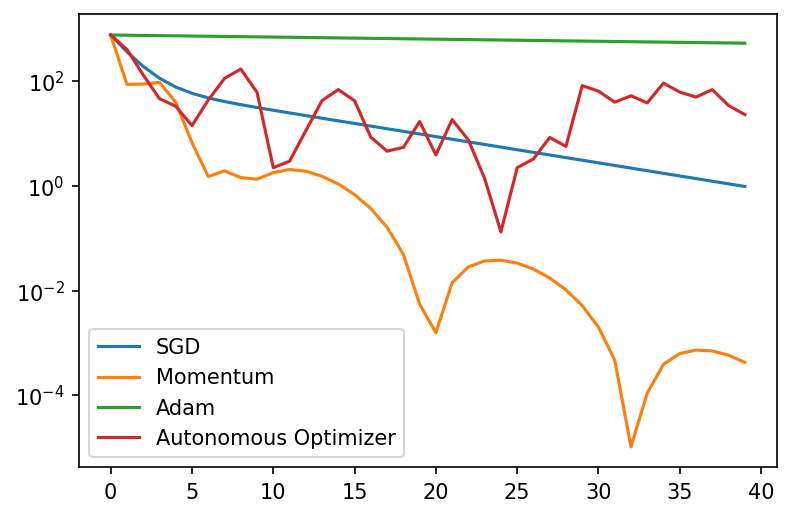

In [23]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(sgd_quadratic_vals - optimal_value, label='SGD')
plt.plot(momentum_quadratic_vals - optimal_value, label='Momentum')
plt.plot(adam_quadratic_vals - optimal_value, label='Adam')
plt.plot(ao_quadratic_vals - optimal_value, label='Autonomous Optimizer')

plt.yscale('log')
plt.legend()
plt.show()

Plotting trajectories on a 2-D slice of the parameter space

In [24]:
all_trajs = np.concatenate([sgd_quadratic_traj, momentum_quadratic_traj, adam_quadratic_traj, ao_quadratic_traj])[:, :2]

minimum = all_trajs.min() - np.abs(all_trajs.min()) * 0.2
maximum = all_trajs.max() + np.abs(all_trajs.max()) * 0.2
X = np.linspace(minimum, maximum)
Y = np.linspace(minimum, maximum)

Z = np.empty((len(Y), len(X)))
for i in range(len(X)):
    for j in range(len(Y)):
        x = torch.tensor(optimal_x.copy())
        x[0] = X[i]
        x[1] = Y[j]
        Z[j, i] = obj_function(x)

plt.figure(figsize=(10, 6), dpi=500)
plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

plt.plot(sgd_quadratic_traj[:, 0], sgd_quadratic_traj[:, 1], label='SGD')
plt.plot(momentum_quadratic_traj[:, 0], momentum_quadratic_traj[:, 1], label='Momentum')
plt.plot(adam_quadratic_traj[:, 0], adam_quadratic_traj[:, 1], label='Adam')

plt.plot(sgd_quadratic_traj[0, 0], sgd_quadratic_traj[0, 1], 'bo')
plt.plot(optimal_x[0], optimal_x[1], marker=(5,1), color='red', markersize=12)
plt.legend()

plt.plot()
plt.show()

IndexError: too many indices for array